# Augmentation of datasets

This notebook contain the procedure for augmentation of my data sets.

[Albumnetation  documentation for semantic segmentation](https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/)



###3 datasets are augmented



1.   Augmentation 1 (aug_little): little augmentation are applied to the train dataset.
2.   Augmentation 2 (aug_more): more augmentation are applied to the train dataset.
3.   aug_val: augmentation is applied to the validation dataset. The transformations are the same as in Augmentation 2.




In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# set path
%cd '/content/gdrive/MyDrive/Speciale'

/content/gdrive/MyDrive/Speciale


In [ ]:
# import dependencies

from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader

cudnn.benchmark = True

In [ ]:
# Define datasets with original images/masks

images_directory = 'datasets/images/train_val'
masks_directory = 'datasets/mask/train_val'

images_filenames = list(sorted(os.listdir(images_directory)))

# randomize
random.seed(42)
random.shuffle(images_filenames)

# Split the dataset into train, validation, and test sets
train_images_filenames = images_filenames[:238]
val_images_filenames = images_filenames[238:]
print(len(train_images_filenames), len(val_images_filenames))

238 60


### Inspect the augmentations

In [ ]:
def preprocess_mask(mask):
  if mask is not None:
    mask = mask.astype(np.float32)
    return mask

In [ ]:

def display_image_grid(images_filenames, images_directory, masks_directory, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = len(images_filenames)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i, image_filename in enumerate(images_filenames):
        image = cv2.imread(os.path.join(images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(os.path.join(masks_directory, image_filename.replace(".jpg", ".png")),cv2.IMREAD_UNCHANGED, )
        mask = preprocess_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Annotation")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

In [ ]:
#subset= val_images_filenames[:2]
display_image_grid(train_images_filenames, images_directory, masks_directory)

In [ ]:
class eelgrass(Dataset):
  def __init__(self, images_filenames, images_directory, masks_directory, transform=None):
    self.images_filenames = images_filenames
    self.images_directory = images_directory
    self.masks_directory = masks_directory
    self.transform = transform

  def __len__(self):
    return len(self.images_filenames)

  def __getitem__(self, idx):
    image_filename = self.images_filenames[idx]
    image = cv2.imread(os.path.join(self.images_directory, image_filename))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(
        os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png")),  cv2.IMREAD_UNCHANGED,
        )
    mask = preprocess_mask(mask)
    if self.transform is not None:
      transformed = self.transform(image=image, mask=mask)
      image = transformed["image"]
      mask = transformed["mask"]
      return image, mask

In [ ]:
# augment dataset
train_transform = A.Compose(
    [
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
      A.RandomRotate90(p=0.5),
      A.GaussianBlur(blur_limit=(3, 15), sigma_limit=(0, 3)),
      A.RandomBrightnessContrast(p=0.2),
      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
      ToTensorV2(),
    ],
)
train_dataset =eelgrass(train_images_filenames, images_directory, masks_directory, transform=train_transform,)

val_transform = A.Compose(
    [A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
     ToTensorV2()],
)
val_dataset = eelgrass(val_images_filenames, images_directory, masks_directory, transform=val_transform,)

In [ ]:

def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset) # ensures that no modifications are made on the original dataset
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image, mask = dataset[idx]
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

In [ ]:
random.seed(42)
visualize_augmentations(train_dataset, idx=1)

### Create augmented datasets

In [ ]:
# define class to load data
class eelgrass_aug(Dataset):
  def __init__(self, images_filenames, images_directory, masks_directory, transform=None):
    self.images_filenames = images_filenames
    self.images_directory = images_directory
    self.masks_directory = masks_directory
    self.transform = transform

  def __len__(self):
    return len(self.images_filenames)

  def __getitem__(self, idx):
    image_filename = self.images_filenames[idx]
    image = cv2.imread(os.path.join(self.images_directory, image_filename))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(
        os.path.join(self.masks_directory, image_filename.replace('.jpg', '_mask.png')),  cv2.IMREAD_UNCHANGED,)

    return image, mask

In [ ]:
# create datasets
train_dataset = eelgrass_aug(train_images_filenames, images_directory, masks_directory, transform=None)
val_dataset = eelgrass_aug(val_images_filenames, images_directory, masks_directory, transform=None)

In [ ]:
# Define augmentations

# Define which transformations should be used
# transforms_little = [
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.RandomRotate90(p=0.5),
#     A.GaussianBlur(blur_limit=(3, 15), sigma_limit=(0, 3)),
#     A.RandomBrightnessContrast(p=0.5),
# ]

transforms_more = [
    A.HorizontalFlip(p=0.75),
    A.VerticalFlip(p=0.75),
    A.RandomRotate90(p=0.75),
    A.GaussianBlur(blur_limit=(3, 15), sigma_limit=(0, 5)),
    A.RandomBrightnessContrast(p=0.9),
    A.GridDistortion(p=0.25)
]

# Define directories for images and masks
save_image_dir = 'dataset_aug/img_val_augented_more'
save_mask_dir = 'dataset_aug/mask_val_augmented_more'
os.makedirs(save_image_dir, exist_ok=True)
os.makedirs(save_mask_dir, exist_ok=True)

# Function to apply augmentation and save the augmented images and masks
def augment_and_save(image, mask, save_image_dir, save_mask_dir, idx, transforms):
    for j, transform in enumerate(transforms):
        augmented = transform(image=image, mask=mask)
        augmented_image = augmented['image']
        augmented_mask = augmented['mask']

        # Save augmented images and masks
        cv2.imwrite(os.path.join(save_image_dir, f'image_{idx}_{j}.jpg'), cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))
        cv2.imwrite(os.path.join(save_mask_dir, f'mask_{idx}_{j}.png'), augmented_mask)


# Functio to apply augmentation
def augment_dataset(dataset, save_image_dir, save_mask_dir, transforms):
    for i, (image, mask) in enumerate(dataset):
        augment_and_save(image, mask, save_image_dir, save_mask_dir, i+1, transforms)

# Augment dataset
augment_dataset(val_dataset, save_image_dir, save_mask_dir, transforms_more)


In [ ]:
# save new val dataset that correspond to the aug_split with seed = 42
# val dataset is not augmented!

# Define the save directories for images and masks
save_image_dir = 'dataset_aug/img_train'
save_mask_dir = 'dataset_aug/mask_train'
os.makedirs(save_image_dir, exist_ok=True)
os.makedirs(save_mask_dir, exist_ok=True)

# save validataion dataset in new directories
def save_dataset(dataset, save_image_dir, save_mask_dir):
    for i, (image, mask) in enumerate(dataset):
        cv2.imwrite(os.path.join(save_image_dir, f'image_{i}.jpg'), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        cv2.imwrite(os.path.join(save_mask_dir, f'mask_{i}.png'), mask)


# Augment dataset
save_dataset(train_dataset, save_image_dir, save_mask_dir)


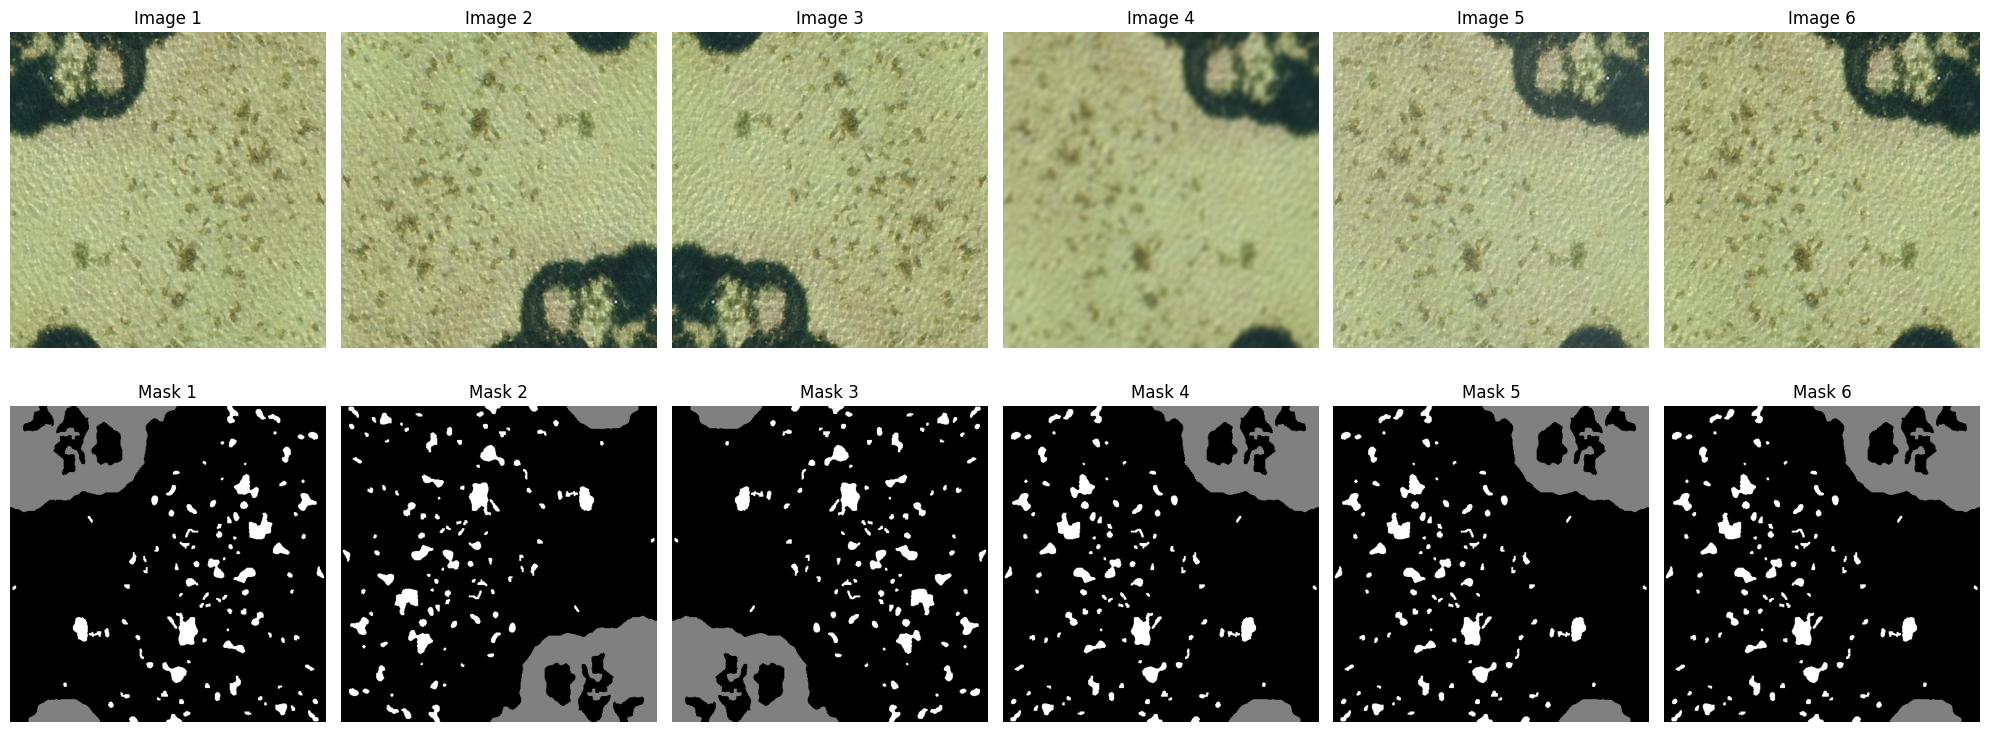

In [ ]:
# Show augmentations for a single image

# Define directories
images_directory = 'dataset_aug/img_train_aug_more'
masks_directory = 'dataset_aug/mask_train_aug_more'

# Example index
image_number = 10

# plot
fig, axes = plt.subplots(2, 6, figsize=(20, 8))

for i in range(6):
    image_path = os.path.join(images_directory, f'image_{image_number}_{i}.jpg')
    mask_path = os.path.join(masks_directory, f'mask_{image_number}_{i}.png')
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Image {i+1}')
    axes[0, i].axis('off')

    axes[1, i].imshow(mask, cmap='gray')
    axes[1, i].set_title(f'Mask {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()
